# [E-05] 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

* 루브릭 평가기준
    * 캐글 데이터분석 전과정이 성공적으로 진행되었는가: 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.
    * 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가: 제출된 노트북이 캐글 커널로 사용될 수 있을만큼 전처리, 최적화 진행 과정이 체계적으로 기술되었다.
    * 회귀모델 예측 정확도가 기준 이상 높게 나왔는가: 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000이하의 점수를 얻었다.

### 라이브러리 import, 데이터 불러오기

In [32]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [34]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 전처리

In [35]:
# 결측치 찾아보기
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [36]:
# 타겟 데이터를 따로 저장해주고 train에서는 삭제한다.
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
# 학습 데이터와 테스트 데이터 합치기

train_len = len(train) # training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용한다.
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [38]:
# 필요 없는 id 컬럼을 제거한다.
# 나중에 예측 결과를 제출할 때를 대비해 sub_id 변수에 id 컬럼을 저장해두고 지운다.

sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [39]:
# date 컬럼 다듬어주기
data['date'] = data['date'].apply(lambda i: i[:8]).astype(int)  # date를 예측을 위한 특성으로 활용하기 위해 정수형 데이터로 처리한다.
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


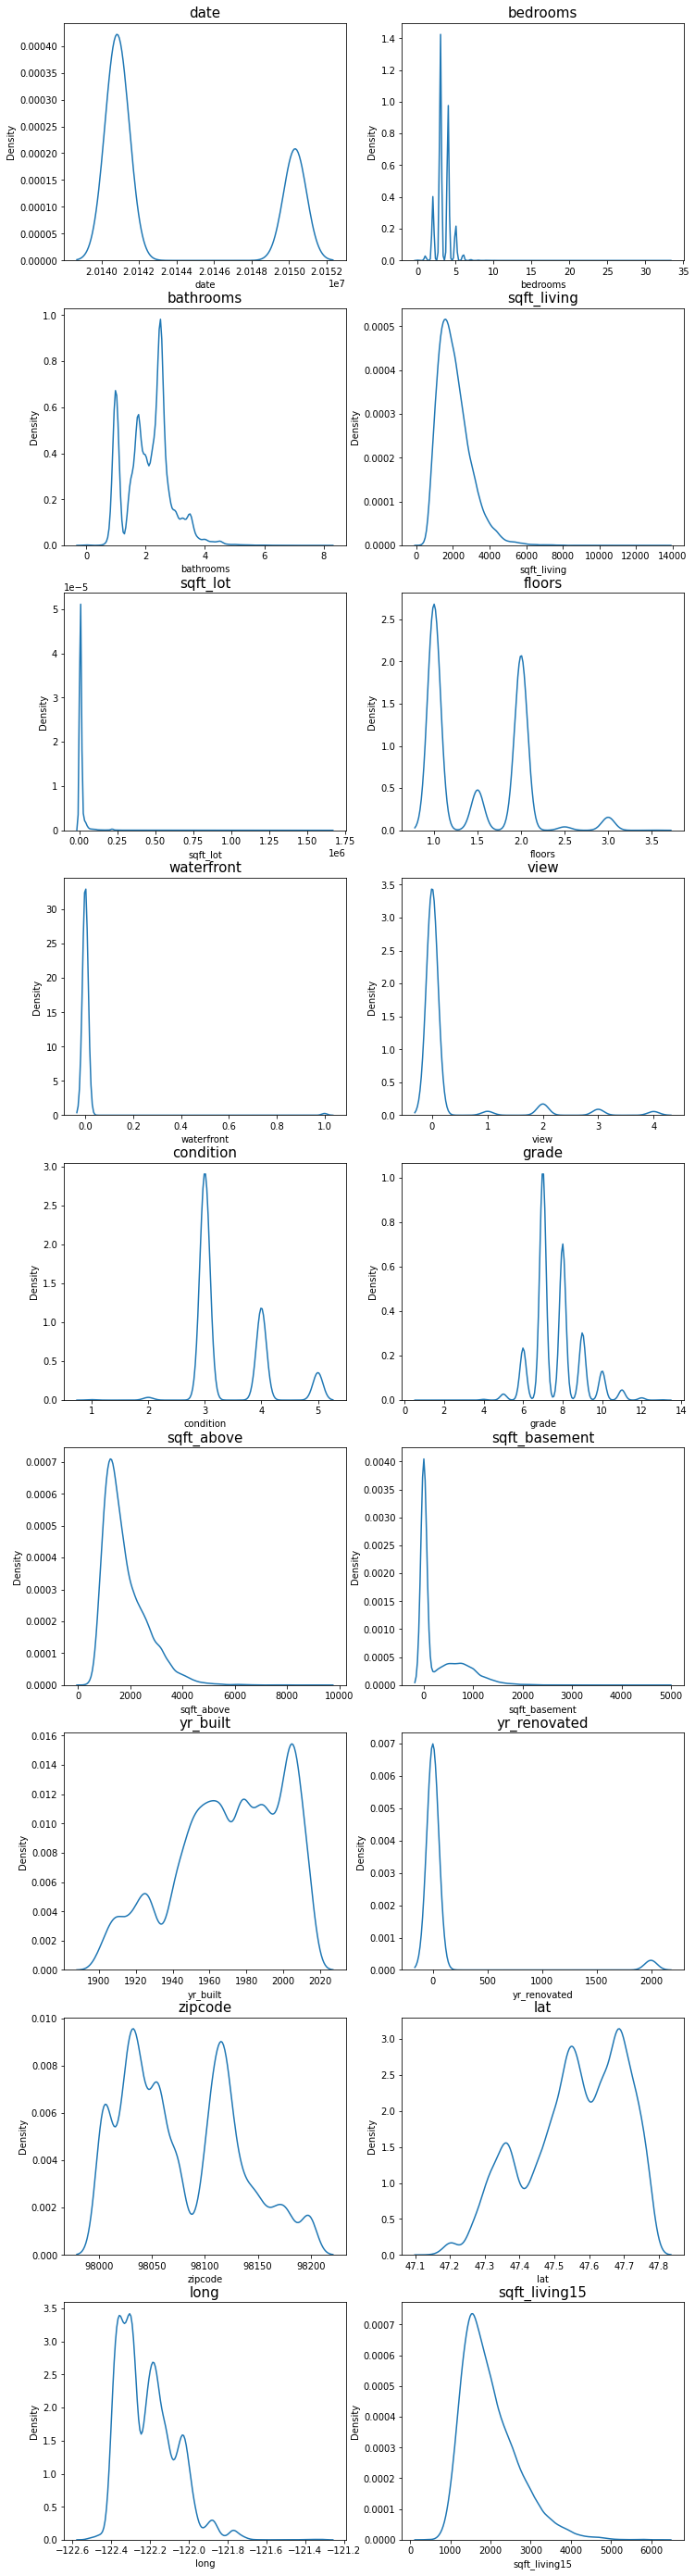

In [40]:
# 다른 컬럼들의 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수는 제외하고 분포 확인
count = 0
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

* 위 그래프를 보면 한쪽으로 치우쳐 있거나 분포가 좋아보이지 않는 컬럼들이 있다. 학습에 좋은 영향을 주지는 않으니까 로그 변환을 통해 정규분포에 가깝게 만들어준다.

In [41]:
# 한쪽으로 치우친 분포를 로그 변환(log-scaling)을 통해 정규분포에 가깝게 만들어준다

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

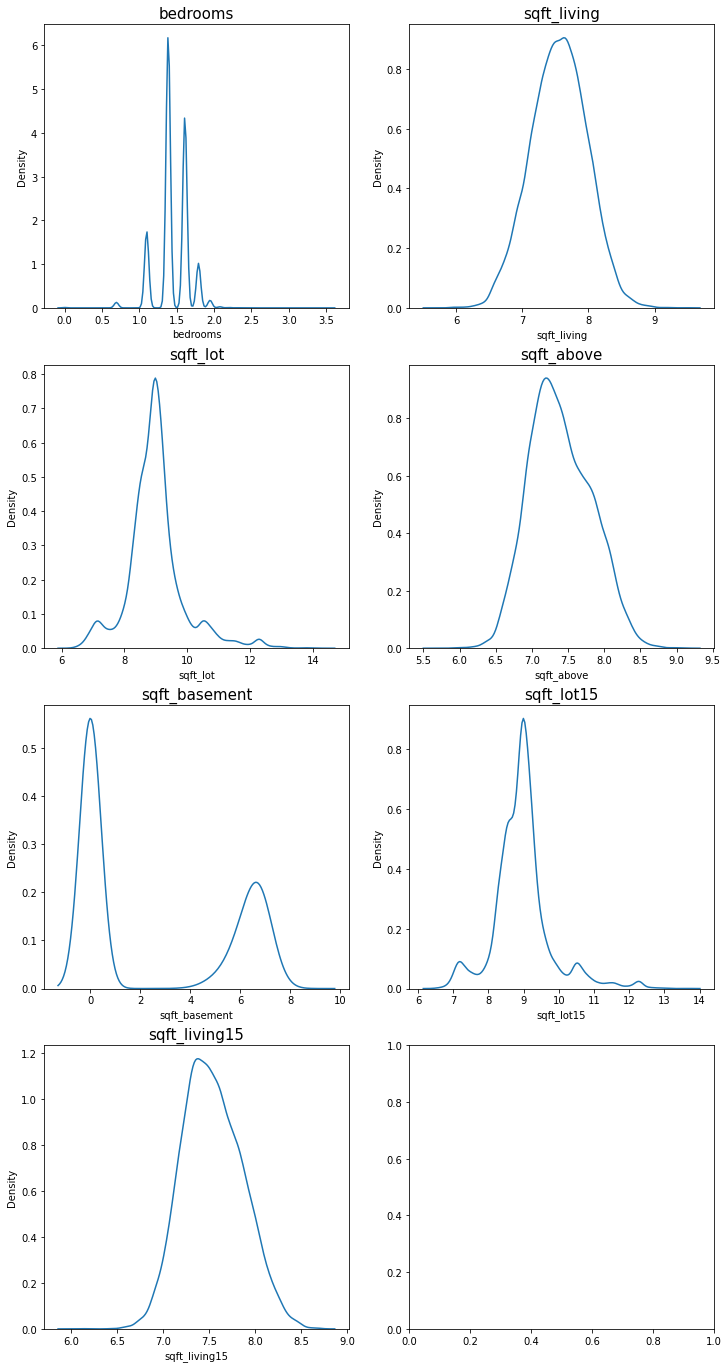

In [42]:
# 로그 변환으로 바꾼 컬럼들의 분포 확인
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

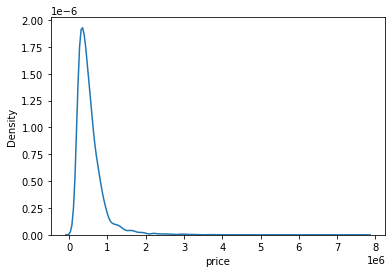

In [43]:
# 타켓 컬럼 y의 분포 확인
sns.kdeplot(y)
plt.show()

* y값 또한 한쪽으로 치우친 것을 볼 수 있다. 로그 변환으로 바꿔준다.

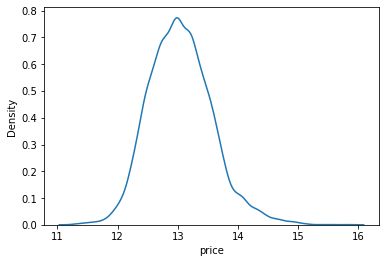

In [44]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

* 이제 합쳤던 train 데이터와 test 데이터를 다시 나누어준다.

In [45]:
test_last = data.iloc[train_len:, :]
train_last = data.iloc[:train_len, :]

print(train_last.shape)
print(test_last.shape)

(15035, 19)
(6468, 19)


In [46]:
print(train_last.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [47]:
print(test_last.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [48]:
train_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

### 모델 설계 및 학습

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [50]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [51]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [53]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값임.
  
random_state=2020        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [gboost, xgboost,lightgbm]

In [54]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_last, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train_last, y)

,RMSE
GradientBoostingRegressor,127023.353828
LGBMRegressor,111008.952321
XGBRegressor,110986.190729


In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train_last, y)

,RMSE
GradientBoostingRegressor,127023.353828
LGBMRegressor,111008.952321
XGBRegressor,110986.190729


In [57]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [58]:
# LGBMRegressor 최적의 파라미터 값 찾기
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [10, 20],
    'learning_rate': [0.05, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_last, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.05,20,1000,-0.026063,0.161439
1,0.05,10,1000,-0.026161,0.161743
7,0.10,20,1000,-0.026617,0.163148
5,0.10,10,1000,-0.026916,0.164062
6,0.10,20,100,-0.026927,0.164095
4,0.10,10,100,-0.027033,0.164418
2,0.05,20,100,-0.028945,0.170132
0,0.05,10,100,-0.029083,0.170536


In [59]:
# XGBRegressor 최적의 파라미터 찾기
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train_last, y, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=  23.4s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=  23.1s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=  23.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=  24.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time=  23.1s
[CV] END .learning_rate=0.05, max_depth=20, n_estimators=100; total time=   3.3s
[CV] END .learning_rate=0.05, max_depth=20, n_est

,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.05,10,1000,-0.026320,0.162234
5,0.10,10,1000,-0.027122,0.164689
4,0.10,10,100,-0.027175,0.164848
3,0.05,20,1000,-0.027708,0.166457
7,0.10,20,1000,-0.028691,0.169384
6,0.10,20,100,-0.028747,0.169550
0,0.05,10,100,-0.035088,0.187318
2,0.05,20,100,-0.036503,0.191058


In [60]:
# GradientBoostingRegressor 최적
model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train_last, y, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   8.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   8.7s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   8.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   8.7s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   8.6s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.4min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.4min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.5min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 1.5min
[CV] END .learning_rate=0.05, max_depth=20, n_estimators=100; total time=  14.4s
[CV] END .learning_rate=0.05, max_depth=20, n_est

,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.05,10,1000,-0.029197,0.170870
0,0.05,10,100,-0.029638,0.172156
4,0.10,10,100,-0.029734,0.172437
5,0.10,10,1000,-0.029800,0.172627
6,0.10,20,100,-0.051913,0.227845
7,0.10,20,1000,-0.051914,0.227845
2,0.05,20,100,-0.052272,0.228631
3,0.05,20,1000,-0.052388,0.228883


In [61]:
params_lgbm = {
    'max_depth' : 20,
    'learning_rate' : 0.10,
    'n_estimators' : 1000,
}

In [67]:
params_xgb = {
    'max_depth' : 10,
    'learning_rate' : 0.05,
}

In [68]:
params_gbr = {
    'max_depth' : 10,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
}

In [69]:
model1 = LGBMRegressor(**params_lgbm, random_state=random_state)
model2 = XGBRegressor(**params_xgb, random_state=random_state)
model3 = GradientBoostingRegressor(**params_gbr, random_state=random_state)

model1.fit(train_last,y)
model2.fit(train_last,y)
model3.fit(train_last,y)

pred1=model1.predict(test_last)
pred2=model2.predict(test_last)
pred3=model3.predict(test_last)

finalpred=(pred1*0.5 + pred2*0.3 + pred3*0.2)
    
prediction = np.expm1(finalpred)
    
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'WA', 'rmsle')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_WA_RMSLE_rmsle.csv saved!


* 모델 학습 부분 참고: https://github.com/youngchurl/EXPLORATION/blob/71906c576751c4fcfd7a888aec85a9b7418d73ba/%5BE-05%5D%20Kaggle%20Starting/%5BE-05%5D%20Kaggle%20Starting.ipynb

### 회고

* 최종 결과

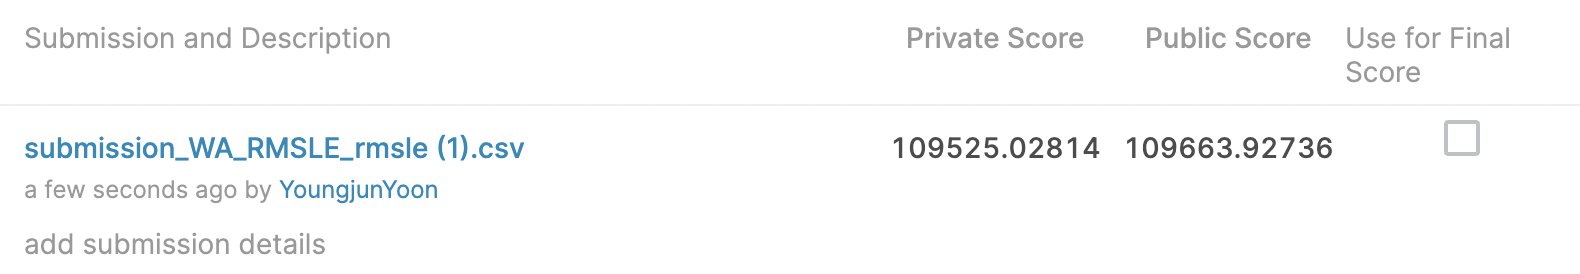

* 11만점 이하를 달성하기 위해
    * 모델 클래스 인자 추가: learning_rate를 추가했고 다음으로 boosting을 추가하려고 했는데 오류가 발생했다. 이유는 아직 모르겠다.
    * gridsearch: 최적의 파라미터 값을 찾기 위해 각각의 모델에 그리디 탐색을 시도하였는데, lgbm을 제외한 두 모델에서 시간이 너무 오래 걸리고 XGBRegressor는 경고만 뜨고 출력이 안돼서 포기했는데 n_jobs를 5가 아닌 1로 수행하면 된다는 걸 알았다.
    * blending: LGBMRegressor, XGBRegressor, GradientBoostingRegressor모델을 학습해 나온 결과에 가중치를 곱한 다음 섞는 blending을 수행하고 난 뒤 최종 109525점을 달성했다.

* 느낀점
    * 이번 노드는 전처리 겉핥기 정도인 것 같다. 해당 kaggle 경진대회에서 다른 사람들이 작성한 코드를 봤는데 피처 엔지니어링을 훨씬 구체적으로 분석한게 보였다. price 예측에 상대적으로 영향을 미치지 않는 컬럼을 전처리 하는 과정이 단순하면서도 확실하게 점수를 올리는 것 같다. 데이터 전처리에서 예측하고자 하는 값과 나머지 컬럼들이 얼마나 관련이 있는지 판단하는 부분에서 그래프를 많이 활용하는 것을 봤는데 아직 그래프를 다루는 부분을 잘 모르겠다. 이번 노드를 통해서 데이터 분석이나 전처리 과정에 대한 전반적인 과정에 대해서 알게됐고 어떤 부분을 더 공부해야할지 윤곽이 잡히기 시작했다.